# AdaBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from random import sample
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('bank-full.csv')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


# Preprocessing

In [3]:
df.isnull().sum().sum()

0

In [4]:
df=df.replace(to_replace=r'unknown', value=np.nan, regex=True)

In [5]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [6]:
df=df.drop(['poutcome','contact','education'], axis=1)

In [7]:
df.pdays=df.pdays.replace(to_replace=-1, value=999, regex=True)

In [8]:
df.job=df.job.fillna('Fresher')

In [9]:
for col in df:
    print(col)    
    print(df[col].unique())
    print("")

age
[58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'Fresher'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital
['married' 'single' 'divorced']

default
['no' 'yes']

balance
[ 2143    29     2 ...  8205 14204 16353]

housing
['yes' 'no']

loan
['no' 'yes']

day
[ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

duration
[ 261  151   76 ... 1298 1246 1556]

campaign
[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]

pdays
[999 151 166  91  86 143 147  89 140 176 101 174 170 167 1

pdays: number of days that passed by after the client was last contacted from a previous campaign 
    (numeric; 999 means client was not previously contacted)

# Plotting Data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002275C143DF0>]],
      dtype=object)

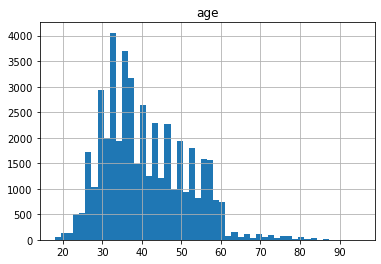

In [10]:
df.hist(column='age',bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002275C252100>]],
      dtype=object)

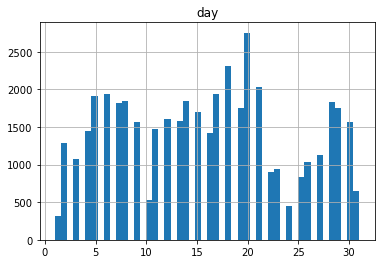

In [11]:
df.hist(column='day',bins=50)

In [12]:
from sklearn import preprocessing
leb = preprocessing.LabelEncoder()


In [13]:
leb.fit(df['marital'].unique())

LabelEncoder()

In [14]:
df['marital']=leb.transform(df['marital'])

# encoding data

In [15]:
leb.fit(df['month'].unique())
df['month']=leb.transform(df['month'])

In [16]:
leb.fit(df['y'].unique())
df['housing']=leb.transform(df['housing'])
df['y']=leb.transform(df['y'])
df['loan']=leb.transform(df['loan'])
df['default']=leb.transform(df['default'])

In [17]:
leb.fit(df['job'].unique())
df['job']=leb.transform(df['job'])

# Preprocessed Data 

In [18]:
df.head()

,age,job,marital,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,5,1,0,2143,1,0,5,8,261,1,999,0,0
1,44,10,2,0,29,1,0,5,8,151,1,999,0,0
2,33,3,1,0,2,1,1,5,8,76,1,999,0,0
3,47,2,1,0,1506,1,0,5,8,92,1,999,0,0
4,33,0,2,0,1,0,0,5,8,198,1,999,0,0


In [19]:
df.to_csv('processed_data.csv') 

# Adaboost

In [20]:
df=df.astype('float64')

## AdaBoost algorithm
Input N examples D = {(x1, y1), ...,(xN , yN )}, xi ∈ X ⊆ Rn, yi ∈ {−1, 1}

T: number of hypotheses in the ensemble Initialize D1(i) = 1/N, i = 1, 2, . . . N 1: for t = 1 to T do

2: Create a sample Dt by sampling D with replacement by taking into consider- ation the data points weights (as given in subsection 3.1)

3: Train a Weak Learner using Dt and obtain the hypothesis ht

: X→ {1, −1}

4: Computed weighted error t = PN i=1 Dt(i){ht(xi)6=yi}

5: If t ≤ 0.5 continue else go to step (2) 6: Compute hypothesis weight αt =1/2*log(1 − t)/t

7: If t < T, update the data points weights: Dt+1(i) = Dt(i)e−yiαtht(xi) PNi=1 Dt(i)e−yiαtht(xi)

8: end for 9: Final vote H(x) = sign(PTt=1 αtht(x)) is the weighted sum.

![image](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_3_nwa5zf.png)

In [21]:
class Adaboost():

    def __init__(self):        
        self.alpha = None
        self.features = None
        self.errors = None
        self.weights = None
        
    def XY(self,df):
        r,c=df.shape
        y=np.array(df['y'])
        x=np.array(df.iloc[:,:(c-2)])
        return x,y
    
    def Train(self, X, y, nclf):        
        n = X.shape[0]
        # init numpy arrays
        self.weights  = np.zeros((nclf,n))
        self.features = np.zeros((nclf)).astype('int')
        self.alpha    = np.zeros((nclf))
        self.errors   = np.zeros((nclf))
        self.threshold= np.zeros((nclf))
        
        
        self.weights[0] = np.ones(n)*( 1/n )
        df= pd.DataFrame(X,columns=None)
        df['y']= y        
        for t in range(nclf):
            # fit  weak learner
            print(' ')
            print("--------------------weak Classifier--",t,"---------------------")
            df['w']= self.weights[t]
            df  = df.sample(len(df), replace = True, weights = df['w'], axis = 0)            
            X, y = self.XY(df)
            w = self.weights[t]
            model = TreeClassify()
            feature ,thre = model.Train(X, y, w)            
            #calculate error and stump weight from weak learner prediction
            y_pred = model.predict(X,feature ,thre)            
            err = w[(y_pred != y)].sum()            
            #Classifier weight
            Hw = np.log((1 - err) / err) / 2 
            # update sample weights
            new_w = (  w * np.exp(- Hw * y * y_pred))
            #normalised
            new_w= new_w / new_w.sum()            
            # If not final iteration, update sample weights for t+1
            if t+1 < nclf:
                self.weights[t+1] = new_w
            # save results of iteration
            self.features[t] = feature
            self.alpha[t] = Hw
            self.errors[t] = err
            self.threshold[t]= thre
            print("-------Feature   choosen------",self.features[t])        
            print("-------Feature threshold------",self.threshold[t]) 
            print("-------Classifier weight------",self.alpha[t]) 
            print(' ')
            
    
    def X_Predict(self, X, y):
        nc=len(self.features)
        n = X.shape[0]
        pred = np.zeros((nc, n))
        for p in range(nc):                        
            for i in (self.features):                
                for g in X[:,i]:
                    if ( g <= self.threshold[p]):                        
                        pred[p]= (-1)
                    else: 
                        pred[p]= (1)
                        
        ypred = np.sign(pred.T @ self.alpha)        
        cm=confusion_matrix(y, ypred)
        print(cm)
        a = np.sum(y == ypred) / len(y)
        print('Model Score---',a*100)
              
    
    
    
class TreeClassify():
    
    def __init__(self):
        self.thresholds = None       
       
    
    def Train(self,X,y,w):
        
        R, C = X.shape
        self.thresholds = [ ]                
        gini=[] 
        thre=[]
        for c in range(C):
            F = X[:, c]
            t = np.sort(np.unique(F))
            z=[ ]
            if(len(t)>2):
                for  i in range(len(t)-1):
                    z.append((t[i]+t[i+1])/2)
                p=[]
                for k in z:
                    p.append(self.gini_impurity(F,y,k))                    
                idx=np.argmin(p)
                thre.append(z[idx])
                gini.append(np.min(p))                     
            else:                
                u=(self.gini_impurity(F,y,k))          
                thre.append(1)
                gini.append(u)
        
        
        f = (np.argmin(gini))           
        self.thresholds.append(thre)
        return f, thre[f]  
    
    def gini_impurity(self,x,y,k):      
        z=[]
        x1,x2 = 0,0
        df  = pd.DataFrame(x,columns=['x'])
        df['y']= y        
        if (len(df.x.unique())) >2 :
            for i in df.x:
                if i < k:
                    z.append(-1)                    
                else:
                    z.append(1)                    
        else:
            for i in df.x:
                if i==0:
                    z.append(-1)
                else:
                    z.append(1) 
        df['z'] = z 
        
        x1=df[df.y == -1]   
        x2=df[df.y == 1] 
        x1_true = len(x1[df.z == df.y])
        x1_false= len(x1[df.z != df.y]) # miss
        x2_true = len(x2[df.z == df.y])
        x2_false= len(x2[df.z != df.y]) # miss
        
        gini1=1-(x1_true/len(x1))**2-(x1_false/len(x1))**2
        
        gini2=1-(x1_true/len(x2))**2-(x2_false/len(x2))**2
        
        gini = (len(x1)/len(x))*gini1 +  (len(x2)/len(x))*gini2        
        return gini    

    def predict(self,x,f,k):
        pred=[]
        for i in x[:,f]:
            if ( i < k):
                pred.append(-1)
            else: 
                pred.append(1)
            
        return np.array(pred)
        

In [22]:
df.head(5)

,age,job,marital,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58.0,5.0,1.0,0.0,2143.0,1.0,0.0,5.0,8.0,261.0,1.0,999.0,0.0,0.0
1,44.0,10.0,2.0,0.0,29.0,1.0,0.0,5.0,8.0,151.0,1.0,999.0,0.0,0.0
2,33.0,3.0,1.0,0.0,2.0,1.0,1.0,5.0,8.0,76.0,1.0,999.0,0.0,0.0
3,47.0,2.0,1.0,0.0,1506.0,1.0,0.0,5.0,8.0,92.0,1.0,999.0,0.0,0.0
4,33.0,0.0,2.0,0.0,1.0,0.0,0.0,5.0,8.0,198.0,1.0,999.0,0.0,0.0


In [23]:
#df  = df.sample(1000,axis = 0).reindex()
n=len(df.columns)
X = np.array(df.iloc[:,:(n-1)])
df.y[df.y == 0] = -1
y = np.array(df.y)


In [25]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

# Adaboost classification with 5 weak classifiers
MOD = Adaboost()
MOD.Train(X_train, y_train,5)
MOD.X_Predict(X_test, y_test)


 
--------------------weak Classifier-- 0 ---------------------
-------Feature   choosen------ 12
-------Feature threshold------ 166.5
-------Classifier weight------ 1.0132879599621665
 
 
--------------------weak Classifier-- 1 ---------------------
-------Feature   choosen------ 4
-------Feature threshold------ 89810.5
-------Classifier weight------ -0.0010550569874756058
 
 
--------------------weak Classifier-- 2 ---------------------
-------Feature   choosen------ 0
-------Feature threshold------ 94.0
-------Classifier weight------ -0.011893444062555766
 
 
--------------------weak Classifier-- 3 ---------------------
-------Feature   choosen------ 0
-------Feature threshold------ 92.5
-------Classifier weight------ 0.004946170488885771
 
 
--------------------weak Classifier-- 4 ---------------------
-------Feature   choosen------ 0
-------Feature threshold------ 92.5
-------Classifier weight------ 0.007948203427073705
 
[[11982     0]
 [ 1582     0]]
Model Score--- 88.3367738130